In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive

ColabNotebooks


In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [ ]:
inputFolder = "/content/drive/MyDrive/ColabNotebooks/model"
outputFolder = "/content/drive/MyDrive/ColabNotebooks/Results"
Discriminator_checkpoint = inputFolder+"/discriminator.pth.tar"
Generator_checkpoint = inputFolder+"/generator.pth.tar"

In [ ]:
class DiscriminatorBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super(DiscriminatorBlock,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,stride,bias = False,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,x):
    return self.conv(x);


In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_channels = 3):
    super(Discriminator,self).__init__()
    self.block1 = nn.Sequential(nn.Conv2d(3,64,4,2,1),nn.LeakyReLU(0.2))
    self.block2 = DiscriminatorBlock(64,128,2)
    self.block3 = DiscriminatorBlock(128,256,2)
    self.block4 = DiscriminatorBlock(256,512,1)
    self.block5 = nn.Conv2d(512,1,4,1,1)

  def forward(self,y):
    x = self.block1(y)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    return self.block5(x)

In [ ]:
Discriminator(3)

Discriminator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (block2): DiscriminatorBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (block3): DiscriminatorBlock(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (block4): DiscriminatorBlock(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negat

In [ ]:
#discriminator = Discriminator(3)
#dummy_input = torch.randn(16, 3,256 , 256) # batch_size, channels, size, size
#out = discriminator(dummy_input)
#out.shape

In [ ]:
class GeneratorBlock(nn.Module):
  def __init__(self,in_channels,out_channels,batchnorm = False,up = False,use_dropout = False):
    super(GeneratorBlock,self).__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,4,2,1,bias=False)
        if up == False else nn.ConvTranspose2d(in_channels,out_channels,4,2,1,bias = False),
    )
    self.batchnorm = batchnorm
    if batchnorm:
      self.block2 = nn.BatchNorm2d(out_channels)

    if up == True:
      self.block3= nn.ReLU()
    else:
      self.block3 = nn.LeakyReLU(0.2)

    self.use_dropout = use_dropout
    if use_dropout:
      self.block4 = nn.Dropout(0.5)


  def forward(self,x):
    x = self.block1(x)
    if self.batchnorm:
      x = self.block2(x)
    x = self.block3(x)
    if self.use_dropout:
      return self.block4(x)
    else:
      return x
    

   

In [ ]:
class Generator(nn.Module):
  def __init__(self,in_channels = 1):
    super(Generator,self).__init__()
    self.d1 = GeneratorBlock(1,64,False,False,False)
    self.d2 = GeneratorBlock(64,128,True,False,False)
    self.d3 = GeneratorBlock(128,256,True,False,False)
    self.d4 = GeneratorBlock(256,512,True,False,False)
    self.d5 = GeneratorBlock(512,512,True,False,False)
    self.d6 = GeneratorBlock(512,512,True,False,False)
    self.d7 = GeneratorBlock(512,512,True,False,False)
    self.bottom = nn.Sequential(
        nn.Conv2d(512,512,4,2,1),
        nn.LeakyReLU(0.2),
    )
    
    self.u1 = GeneratorBlock(512,512,True,True,True)
    self.u2 = GeneratorBlock(1024,512,True,True,True)
    self.u3 = GeneratorBlock(1024,512,True,True,True)
    self.u4 = GeneratorBlock(1024,512,True,True,False)
    self.u5 = GeneratorBlock(1024,256,True,True,False)
    self.u6 = GeneratorBlock(512,128,True,True,False)
    self.u7 = GeneratorBlock(256,64,True,True,False)
    self.up = nn.Sequential(
        nn.ConvTranspose2d(128,2,4,2,1),
        nn.Tanh(),
    )

  def forward(self,x):
    down1 = self.d1(x)
    down2 = self.d2(down1)
    down3 = self.d3(down2)
    down4 = self.d4(down3)
    down5 = self.d5(down4)
    down6 = self.d6(down5)
    down7 = self.d7(down6)
    down8 = self.bottom(down7)
    up1 = self.u1(down8)
    up2 = self.u2(torch.concat([up1,down7],1))
    up3 = self.u3(torch.concat([up2,down6],1))
    up4 = self.u4(torch.concat([up3,down5],1))
    up5 = self.u5(torch.concat([up4,down4],1))
    up6 = self.u6(torch.concat([up5,down3],1))
    up7 = self.u7(torch.concat([up6,down2],1))
    up8 = self.up(torch.concat([up7,down1],1))

    return up8


In [ ]:
generator = Generator()
generator

Generator(
  (d1): GeneratorBlock(
    (block1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (block3): LeakyReLU(negative_slope=0.2)
  )
  (d2): GeneratorBlock(
    (block1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (block2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block3): LeakyReLU(negative_slope=0.2)
  )
  (d3): GeneratorBlock(
    (block1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (block2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block3): LeakyReLU(negative_slope=0.2)
  )
  (d4): GeneratorBlock(
    (block1): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (block2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
!pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 32.7 MB/s 
     |████████████████████████████████| 61 kB 9.4 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.4.4
    Uninstalling fastcore-1.4.4:
      Successfully uninstalled fastcore-1.4.4
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.3
    Uninstalling fastai-2.6.3:
      Successfully uninstalled fastai-2.6.3


In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


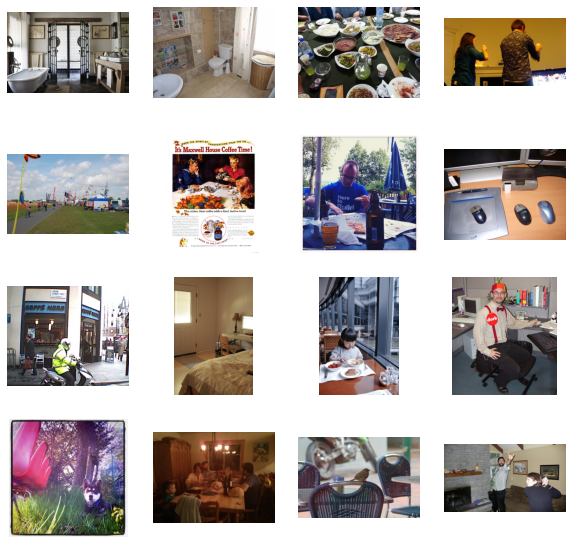

In [ ]:

_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class DataPrep(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

### CHECKKKK FROM     yaha error hai

In [ ]:
def Show_Samples(generator, val_data, folder, epoch= -1, SAVE = True):
    data = next(iter(val_data))
    L = data['L']
    ab = data['ab']
    L=L.to(device)
    ab=ab.to(device)
    # print(ab.shape)
    generator.eval()
    with torch.no_grad():
        fake_ab = generator(L)
    generator.train()
    real_images = lab_to_rgb(L, ab)
    fake_images = lab_to_rgb(L, fake_ab.detach())

    fig = plt.figure(figsize=(20, 10))
    val = 1
    for i in range(3):
      for j in range(5):
        ax = plt.subplot(3,5,val)
        if i==0 :
          if j==0:
            ax.set_ylabel('Grayscale', size='large')
          ax.imshow(L[j][0].cpu(),cmap = 'gray')
        if i==1:
          if j==0:
            ax.set_ylabel('Fake_images', size='large')
          ax.imshow(fake_images[j])
        if i==2:
          if j==0:
            ax.set_ylabel('Real_images', size='large')
          ax.imshow(real_images[j])
        val+=1
    plt.show()
    if SAVE:
        fig.savefig(folder + f"/ResultsAfter{epoch}.png")

In [ ]:
def Visualize_Loss(Arr, folder, epoch, gen, dis, SAVE = True):
    ob=[]
    for i in Arr:
      ob.append(i.cpu().detach().numpy())
    x=(range(0,len(Arr)))
    plt.figure(figsize = (12,10))
    plt.plot(x,ob)
    if dis:
      str = "Discriminator"
    if gen:
      str = "Generator"
    plt.xlabel("Number of Iterations")
    plt.ylabel(str + " Loss")
    if SAVE:
        plt.savefig(folder + f"/{str}LossAfterEpoch{epoch}.png")
    plt.show()

### CHECKKKTO

In [ ]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().detach().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
batch_size = 16
workers = 2
epochs = 250
epoch = 1
L1_lamda = 100.0
in_width = in_height = SIZE  # image size.
c_dim = 3  # no. of channels


In [ ]:
lr_G=2e-4
lr_D=2e-4
beta1=0.5
beta2=0.999
lambda_L1=100.0

In [ ]:
shuffle=True
saveimages= True
pin_memory = True
loadModel= True
SaveModel = True

In [ ]:
Discriminator_loss=[]
Generator_loss=[]
G_agg=0
D_agg=0

In [ ]:
def Save_Checkpoint(model, optimizer, epoch, filename):
    print("=> Saving checkpoint")
    checkpoint = {
        "State_Dictionary": model.state_dict(),
        "Optimizer_State": optimizer.state_dict(),
        "Current_epoch":epoch,
        "LossInDiscriminator" : Discriminator_loss,
        "LossInGenerator" : Generator_loss
    }
    torch.save(checkpoint, filename)

def Load_Checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    global epoch
    global Discriminator_loss
    global Generator_loss
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["State_Dictionary"])
    optimizer.load_state_dict(checkpoint["Optimizer_State"])
    epoch = checkpoint["Current_epoch"]
    Discriminator_loss = checkpoint["LossInDiscriminator"].copy()
    Generator_loss = checkpoint["LossInGenerator"].copy()

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
train_dataset = DataPrep(train_paths)
val_dataset = DataPrep(val_paths)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
train_loader= DataLoader(train_dataset,batch_size = batch_size,shuffle = shuffle,num_workers=workers)
val_loader= DataLoader(val_dataset,batch_size = batch_size,shuffle = shuffle,num_workers=workers)

In [ ]:
get=iter(train_loader)
data=next(get)

In [ ]:
#testing cell

In [ ]:
data = next(iter(train_loader))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_loader), len(val_loader))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
G_optimizer = torch.optim.Adam(G.parameters(), lr_G,betas=(beta1,beta2))
D_optimizer = torch.optim.Adam(D.parameters(), lr_D,betas=(beta1,beta2))

criterion_gan = nn.BCEWithLogitsLoss()
criterion_pixelwise = nn.L1Loss()


### *CHECKKK* FROM

In [ ]:
if loadModel:
    Load_Checkpoint(Generator_checkpoint, G, G_optimizer, lr_G)
    Load_Checkpoint(Discriminator_checkpoint, D, D_optimizer, lr_D)

=> Loading checkpoint
=> Loading checkpoint


In [ ]:
print(epoch)
saveimages
#print(Generator_loss)

2


True

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


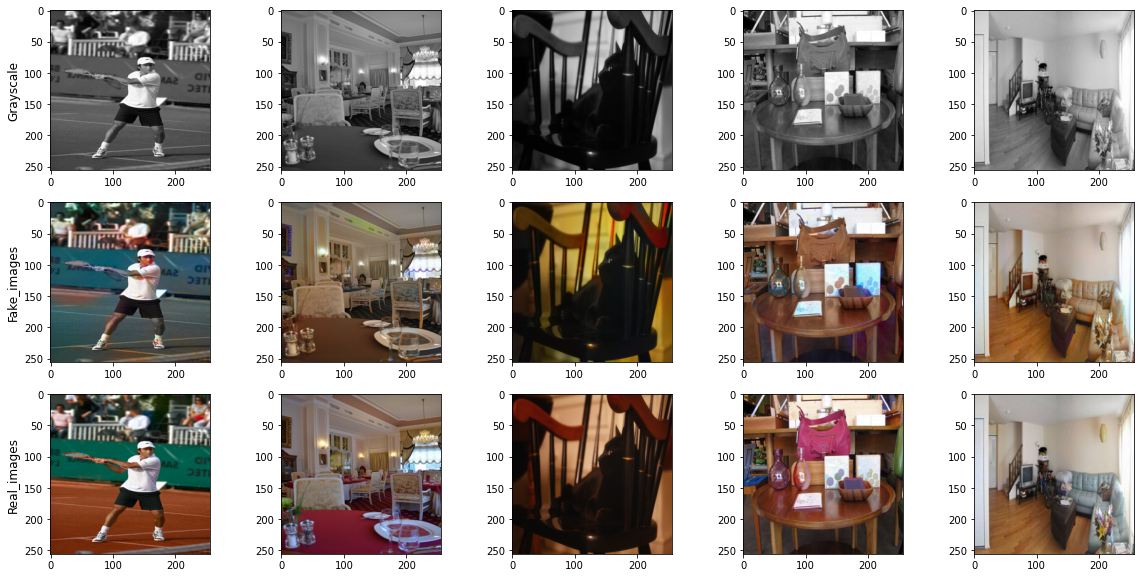

In [ ]:
Show_Samples(G,val_loader,outputFolder,epoch,False)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


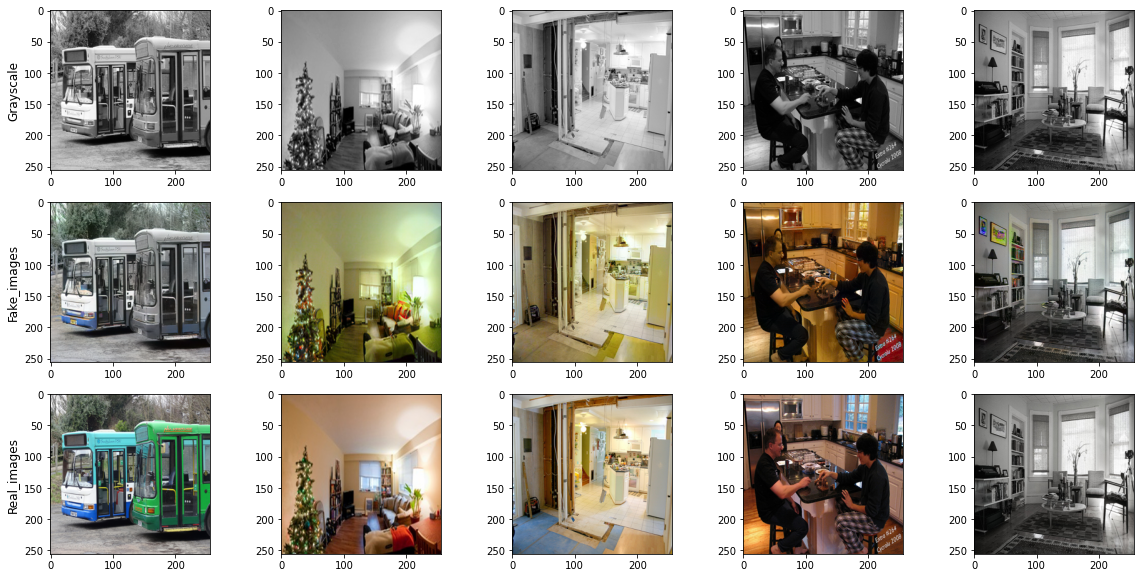

In [ ]:
Show_Samples(G,train_loader,outputFolder,epoch,False)

### CHECKKK TO

In [ ]:
#checkpoints=torch.load('/content/drive/MyDrive/checkpoint/model_status')

### Checkkkk


In [ ]:
epoch+=1;
while epoch <= epochs:
  for i,data in enumerate(train_loader):
    L = data['L'].to(device)
    ab = data['ab'].to(device)

    # TRAIN DISCRIMINATOR
    D_optimizer.zero_grad()

    fake_colour = G(L)

    fake_img = torch.cat([L,fake_colour],1).detach()
    real_img = torch.cat([L,ab],1)
    
    D_fake= D(fake_img)  #changes_applied
    D_real= D(real_img) #changes applied
    D_fake_loss = criterion_gan(D_fake,torch.zeros_like(D_fake))
    D_real_loss = criterion_gan(D_real,torch.ones_like(D_fake))

    total_loss = (D_real_loss+D_fake_loss)*0.5;

    #total_loss.requires_grad = True

    D_agg = total_loss
  
    #d_scaler.scale(total_loss).backward()
    total_loss.backward()

    D_optimizer.step()

    # TRAIN GENERATOR

    G_optimizer.zero_grad()

    fake_colour = G(L)
    fake_ = torch.cat([L,fake_colour],1)
    fake_patch=D(fake_)
   
    G_fake_loss = criterion_gan(fake_patch,torch.ones_like(fake_patch)) # changes applied

    L1_loss = criterion_pixelwise(fake_,torch.concat([L,ab],1))  # changes applied

    G_loss = G_fake_loss + lambda_L1 * L1_loss

    G_agg=G_loss

    G_loss.backward()

    G_optimizer.step()

    Discriminator_loss.append(D_agg)
    Generator_loss.append(G_agg)

  if(epoch % 5 == 0):
    Show_Samples(G, val_loader,outputFolder,epoch,saveimages)
  if SaveModel:
        Save_Checkpoint(G, G_optimizer, epoch, filename= Generator_checkpoint)
        Save_Checkpoint(D, D_optimizer, epoch, filename=Discriminator_checkpoint)
  if epoch % 5 == 0:
        print("Generator Loss\n")
        Visualize_Loss(Generator_loss,outputFolder,epoch,True,False,saveimages)
        print("Discriminator Loss\n")
        Visualize_Loss(Discriminator_loss,outputFolder,epoch,False,True,saveimages)
  print("Epochs done: ",epoch)
  epoch+=1


=> Saving checkpoint
=> Saving checkpoint
Epochs done:  2


### Generator Loss

In [ ]:
Visualize_Loss(Generator_loss,outputFolder,epoch,True,False,False)

### Discriminator Loss

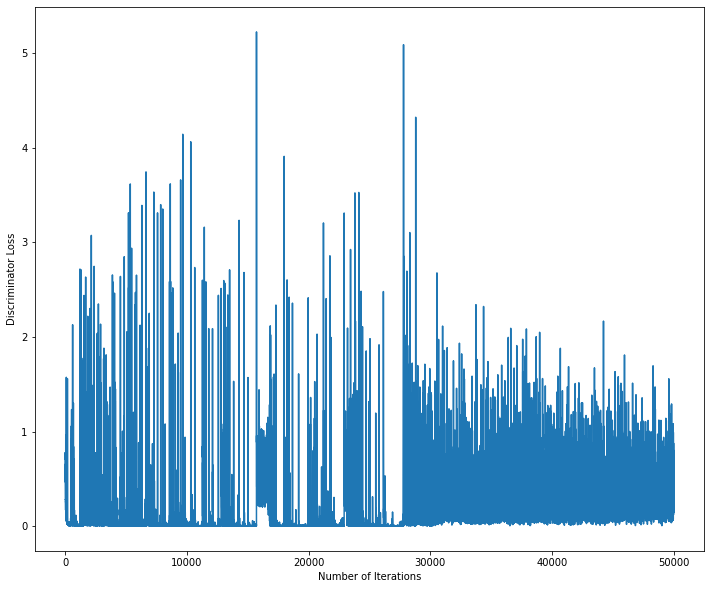

In [ ]:
Visualize_Loss(Discriminator_loss,outputFolder,epoch,False,True,False)

### Predictions on Training Data

In [ ]:
num = 5 #Generate numRuns*5 Samples

In [ ]:
for n in range(num):
    Show_Samples(G, train_loader,outputFolder,epoch,False)

In [ ]:
for n in range(num):
    Show_Samples(G, val_loader,outputFolder,epoch,False)